<a href="https://colab.research.google.com/github/THANNAGA/generalized_Lotka_Volterra_Interactive_Activation/blob/main/gLIA_words2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
!pip install torchdiffeq

## Dataset

## Imports and Arguments

In [131]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.use('Agg')

class Args:
    network = 'resnet'
    tol = 1e-3
    adjoint = False
    downsampling_method = 'conv'
    nepochs = 10
    data_aug = False
    lr = 0.00001
    batch_size = 25
    test_batch_size = 25
    save = './experiment_synth'
    debug = False
    gpu = 0

args = Args()

if args.adjoint:
    odeint = odeint_adjoint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Dataset

In [132]:
# --- Word List (1,000 words) ---
full_wordlist = [
    "the", "of", "to", "and", "a", "in", "is", "it", "you", "that",
    "he", "was", "for", "on", "are", "with", "as", "I", "his", "they",
    "be", "at", "one", "have", "this", "from", "or", "had", "by", "not",
    "word", "but", "what", "some", "we", "can", "out", "other", "were", "all",
    "there", "when", "up", "use", "your", "how", "said", "an", "each", "she",
    "which", "do", "their", "time", "if", "will", "way", "about", "many", "then",
    "them", "write", "would", "like", "so", "these", "her", "long", "make", "thing",
    "see", "him", "two", "has", "look", "more", "day", "could", "go", "come",
    "did", "number", "sound", "no", "most", "people", "my", "over", "know", "water",
    "than", "call", "first", "who", "may", "down", "side", "been", "now", "find",
    "any", "new", "work", "part", "take", "get", "place", "made", "live", "where",
    "after", "back", "little", "only", "round", "man", "year", "came", "show", "every",
    "good", "me", "give", "our", "under", "name", "very", "through", "just", "form",
    "sentence", "great", "think", "say", "help", "low", "line", "differ", "turn", "cause",
    "much", "mean", "before", "move", "right", "boy", "old", "too", "same", "tell",
    "does", "set", "three", "want", "air", "well", "also", "play", "small", "end",
    "put", "home", "read", "hand", "port", "large", "spell", "add", "even", "land",
    "here", "must", "big", "high", "such", "follow", "act", "why", "ask", "men",
    "change", "went", "light", "kind", "off", "need", "house", "picture", "try", "us",
    "again", "animal", "point", "mother", "world", "near", "build", "self", "earth", "father",
    "head", "stand", "own", "page", "should", "country", "found", "answer", "school", "grow",
    "study", "still", "learn", "plant", "cover", "food", "sun", "four", "between", "state",
    "keep", "eye", "never", "last", "let", "thought", "city", "tree", "cross", "farm",
    "hard", "start", "might", "story", "saw", "far", "sea", "draw", "left", "late",
    "run", "dont", "while", "press", "close", "night", "real", "life", "few", "north",
    "open", "seem", "together", "next", "white", "children", "begin", "got", "walk", "example",
    "ease", "paper", "group", "always", "music", "those", "both", "mark", "often", "letter",
    "until", "mile", "river", "car", "feet", "care", "second", "book", "carry", "took",
    "science", "eat", "room", "friend", "began", "idea", "fish", "mountain", "stop", "once",
    "base", "hear", "horse", "cut", "sure", "watch", "color", "face", "wood", "main",
    "enough", "plain", "girl", "usual", "young", "ready", "above", "ever", "red", "list",
    "though", "feel", "talk", "bird", "soon", "body", "dog", "family", "direct", "pose",
    "leave", "song", "measure", "door", "product", "black", "short", "numeral", "class", "wind",
    "question", "happen", "complete", "ship", "area", "half", "rock", "order", "fire", "south",
    "problem", "piece", "told", "knew", "pass", "since", "top", "whole", "king", "space",
    "heard", "best", "hour", "better", "true", "during", "hundred", "five", "remember", "step",
    "early", "hold", "west", "ground", "interest", "reach", "fast", "verb", "sing", "listen",
    "six", "table", "travel", "less", "morning", "ten", "simple", "several", "vowel", "toward",
    "war", "lay", "against", "pattern", "slow", "center", "love", "person", "money", "serve",
    "appear", "road", "map", "rain", "rule", "govern", "pull", "cold", "notice", "voice",
    "unit", "power", "town", "fine", "certain", "fly", "fall", "lead", "cry", "dark",
    "machine", "note", "wait", "plan", "figure", "star", "box", "noun", "field", "rest",
    "correct", "able", "pound", "done", "beauty", "drive", "stood", "contain", "front", "teach",
    "week", "final", "gave", "green", "oh", "quick", "develop", "ocean", "warm", "free",
    "minute", "strong", "special", "mind", "behind", "clear", "tail", "produce", "fact", "street",
    "inch", "multiply", "nothing", "course", "stay", "wheel", "full", "force", "blue", "object",
    "decide", "surface", "deep", "moon", "island", "foot", "system", "busy", "test", "record",
    "boat", "common", "gold", "possible", "plane", "stead", "dry", "wonder", "laugh", "thousand",
    "ago", "ran", "check", "game", "shape", "equate", "hot", "miss", "brought", "heat",
    "snow", "tire", "bring", "yes", "distant", "fill", "east", "paint", "language", "among",
    "grand", "ball", "yet", "wave", "drop", "heart", "am", "present", "heavy", "dance",
    "engine", "position", "arm", "wide", "sail", "material", "size", "vary", "settle", "speak",
    "weight", "general", "ice", "matter", "circle", "pair", "include", "divide", "syllable", "felt",
    "perhaps", "pick", "sudden", "count", "square", "reason", "length", "represent", "art", "subject",
    "region", "energy", "hunt", "probable", "bed", "brother", "egg", "ride", "cell", "believe",
    "fraction", "forest", "sit", "race", "window", "store", "summer", "train", "sleep", "prove",
    "lone", "leg", "exercise", "wall", "catch", "mount", "wish", "sky", "board", "joy",
    "winter", "sat", "written", "wild", "instrument", "kept", "glass", "grass", "cow", "job",
    "edge", "sign", "visit", "past", "soft", "fun", "bright", "gas", "weather", "month",
    "million", "bear", "finish", "happy", "hope", "flower", "clothe", "strange", "gone", "jump",
    "baby", "eight", "village", "meet", "root", "buy", "raise", "solve", "metal", "whether",
    "push", "seven", "paragraph", "third", "shall", "held", "hair", "describe", "cook", "floor",
    "either", "result", "burn", "hill", "safe", "cat", "century", "consider", "type", "law",
    "bit", "coast", "copy", "phrase", "silent", "tall", "sand", "soil", "roll", "temperature",
    "finger", "industry", "value", "fight", "lie", "beat", "excite", "natural", "view", "sense",
    "ear", "else", "quite", "broke", "case", "middle", "kill", "son", "lake", "moment",
    "scale", "loud", "spring", "observe", "child", "straight", "consonant", "nation", " Refresh", "milk",
    "speed", "method", "organ", "pay", "age", "section", "dress", "cloud", "surprise", "quiet",
    "stone", "tiny", "climb", "cool", "design", "poor", "lot", "experiment", "bottom", "key",
    "iron", "single", "stick", "flat", "twenty", "skin", "smile", "crease", "hole", "trade",
    "melody", "trip", "office", "receive", "row", "mouth", "exact", "symbol", "die", "least",
    "trouble", "shout", "except", "wrote", "seed", "tone", "join", "suggest", "clean", "break",
    "lady", "yard", "rise", "bad", "blow", "oil", "blood", "touch", "grew", "cent",
    "mix", "team", "wire", "cost", "lost", "brown", "wear", "garden", "equal", "sent",
    "choose", "fell", "fit", "flow", "fair", "bank", "collect", "save", "control", "decimal",
    "gentle", "woman", "captain", "practice", "separate", "difficult", "doctor", "please", "protect", "noon",
    "whose", "locate", "ring", "character", "insect", "caught", "period", "indicate", "radio", "spoke",
    "atom", "human", "history", "effect", "electric", "expect", "crop", "modern", "element", "hit",
    "student", "corner", "party", "supply", "bone", "rail", "imagine", "provide", "agree", "thus",
    "capital", "wont", "chair", "danger", "fruit", "rich", "thick", "soldier", "process", "operate",
    "guess", "necessary", "sharp", "wing", "create", "neighbor", "wash", "bat", "rather", "crowd",
    "corn", "compare", "poem", "string", "bell", "depend", "meat", "rub", "tube", "famous",
    "dollar", "stream", "fear", "sight", "thin", "triangle", "planet", "hurry", "chief", "colony",
    "clock", "mine", "tie", "enter", "major", "fresh", "search", "send", "yellow", "gun",
    "allow", "print", "dead", "spot", "desert", "suit", "current", "lift", "rose", "continue",
    "block", "chart", "hat", "sell", "success", "company", "subtract", "event", "particular", "deal",
    "swim", "term", "opposite", "wife", "shoe", "shoulder", "spread", "arrange", "camp", "invent",
    "cotton", "born", "determine", "quart", "nine", "truck", "noise", "level", "chance", "gather",
    "shop", "stretch", "throw", "shine", "property", "column", "molecule", "select", "wrong", "gray",
    "repeat", "require", "broad", "prepare", "salt", "nose", "plural", "anger", "claim", "continent",
    "oxygen", "sugar", "death", "pretty", "skill", "women", "season", "solution", "magnet", "silver",
    "thank", "branch", "match", "suffix", "especially", "fig", "afraid", "huge", "sister", "steel",
    "discuss", "forward", "similar", "guide", "experience", "score", "apple", "bought", "led", "pitch",
    "coat", "mass", "card", "band", "rope", "slip", "win", "dream", "evening", "condition",
    "feed", "tool", "total", "basic", "smell", "valley", "nor", "double", "seat", "arrive",
    "master", "track", "parent", "shore", "division", "sheet", "substance", "favor", "connect", "post",
    "spend", "chord", "fat", "glad", "original", "share", "station", "dad", "bread", "charge",
    "proper", "bar", "offer", "segment", "slave", "duck", "instant", "market", "degree", "populate",
    "chick", "dear", "enemy", "reply", "drink", "occur", "support", "speech", "nature", "range",
    "steam", "motion", "path", "liquid", "log", "meant", "quotient", "teeth", "shell", "neck"
]


In [133]:
# Dataset Definition (unchanged)
class TinySynthWordDataset(Dataset):
    def __init__(self, word_list, num_words, exemplars_per_word=10, transform=None):
        self.transform = transform
        self.exemplars_per_word = exemplars_per_word
        self.words = word_list[:num_words]
        self.label_map = {word: idx for idx, word in enumerate(self.words)}
        self.images = []
        self.labels = []
        print(f"Generating tiny synthetic dataset with {num_words} words...")
        for word in self.words:
            for _ in range(exemplars_per_word):
                img = self._generate_word_image(word)
                self.images.append(img)
                self.labels.append(self.label_map[word])
        self.images = torch.stack(self.images)

    def _generate_word_image(self, word):
        img = Image.new('L', (64, 32), color=255)
        draw = ImageDraw.Draw(img)
        font_size = random.randint(12, 18)
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
        except OSError:
            font = ImageFont.load_default()
        text_size = draw.textlength(word, font=font) if font else len(word) * 6
        x = random.randint(2, max(2, 64 - int(text_size) - 2))
        y = random.randint(2, max(2, 32 - font_size - 2))
        draw.text((x, y), word, fill=0, font=font)
        return transforms.ToTensor()(img)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [134]:
from torch.utils.data import Dataset
from torchvision import transforms
import random
from PIL import Image, ImageDraw, ImageFont
import torch

class TinySynthWordDataset(Dataset):
    def __init__(self, word_list, num_words, exemplars_per_word=10, transform=None):
        self.transform = transform
        self.exemplars_per_word = exemplars_per_word
        self.words = word_list[:num_words]
        self.label_map = {word: idx for idx, word in enumerate(self.words)}
        self.images = []
        self.labels = []
        print(f"Generating tiny synthetic dataset with {num_words} words...")
        for idx, word in enumerate(self.words):  # Use index explicitly
            for _ in range(exemplars_per_word):
                img = self._generate_word_image(word)
                self.images.append(img)
                self.labels.append(idx)  # Assign correct label
        self.images = torch.stack(self.images)
        # Verify alignment
        print("Verifying dataset...")
        for i, (img, label) in enumerate(self):
            expected_word = self.words[label]
            #print(f"Index {i}: Label {label}, Expected word: {expected_word}")

    def _generate_word_image(self, word):
        img = Image.new('L', (64, 32), color=255)
        draw = ImageDraw.Draw(img)
        font_size = random.randint(12, 18)
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
        except OSError:
            font = ImageFont.load_default()
        text_size = draw.textlength(word, font=font) if font else len(word) * 6
        x = random.randint(2, max(2, 64 - int(text_size) - 2))
        y = random.randint(2, max(2, 32 - font_size - 2))
        draw.text((x, y), word, fill=0, font=font)
        return transforms.ToTensor()(img)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [135]:
# Dataset and DataLoader
num_words = 1000
exemplars_per_word = 100
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = TinySynthWordDataset(full_wordlist, num_words=num_words, exemplars_per_word=exemplars_per_word, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

Generating tiny synthetic dataset with 1000 words...
Verifying dataset...


Visualizing samples...
torch.Size([25, 3, 32, 64])
Visualizing 10 synthetic samples...


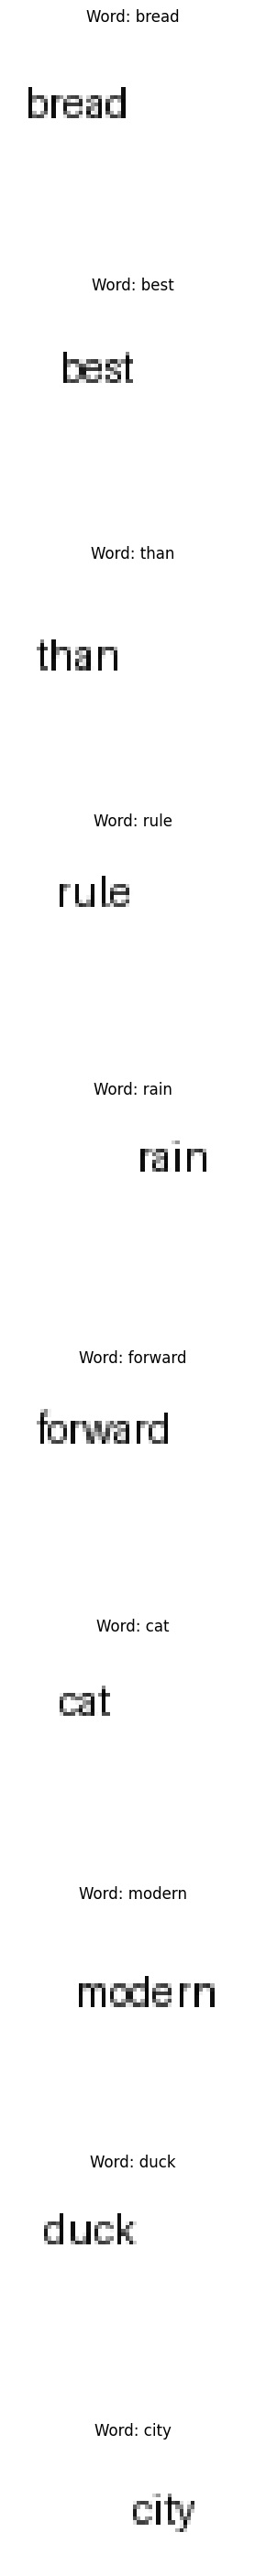

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_samples(loader, dataset, num_samples=5, predicted=None):  # Added predicted parameter
    # Get one batch of data
    images, labels = next(iter(loader))
    batch_size = images.size(0)  # Actual number of images in batch
    print (images.size())

    # Use minimum of requested samples and available batch size
    num_to_show = min(num_samples, batch_size)

    # Create inverse mapping of labels to words
    index_to_word = {idx: word for word, idx in dataset.label_map.items()}

    print(f"Visualizing {num_to_show} synthetic samples...")

    # Create subplots in one column and multiple rows
    fig, axes = plt.subplots(num_to_show, 1, figsize=(3, 3 * num_to_show))
                                                    # Width, Height (adjusted for vertical layout)

    # Loop through images and display them
    for i in range(num_to_show):
        img = images[i].permute(1, 2, 0).numpy()  # Convert CHW to HWC format
        img = (img * 0.5) + 0.5  # Denormalize from [-1,1] to [0,1]
        axes[i].imshow(img)  # Display image on the current subplot

        # Use predicted labels if provided, otherwise use original labels
        title_label = predicted[i].item() if predicted is not None else labels[i].item()

        # Add "pred" or "predicted" to the title if predicted is provided
        title_prefix = "Pred: " if predicted is not None else "Word: "
        axes[i].set_title(f"{title_prefix}{index_to_word[title_label]}")

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing samples...")
visualize_samples(train_loader, dataset, num_samples=10)

## Model

In [137]:
# Helper Functions (unchanged)
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)

class ResBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x
        out = self.relu(self.norm1(x))
        if self.downsample is not None:
            shortcut = self.downsample(out)
        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)
        return out + shortcut

# ODE Function (Operates on 64 + num_words)
class SimpleODEFunc(nn.Module):
    def __init__(self, dim):
        super(SimpleODEFunc, self).__init__()
        epsilon = 0.0001 if dim < 100 else 0.000001
        self.linear = nn.Linear(dim, dim, bias=False)  # dim = 64 + num_words
        self.linear.weight.data[-num_words:, -num_words:] = epsilon * (torch.eye(num_words).to(device) - torch.ones(num_words, num_words).to(device))
        self.relu = nn.ReLU(inplace=True)
        self.r = nn.Parameter(epsilon * torch.ones(dim)).to(device)

    def forward(self, t, x):
        out = x*(self.r + self.linear(x))
        #out = self.relu(out)
        return out

# ODE Network with ODE as Last Layer
class MyODENetwork(nn.Module):
    def __init__(self, downsampling_layers, feature_layers, ode_func, num_words):
        super(MyODENetwork, self).__init__()
        self.downsampling = nn.Sequential(*downsampling_layers)
        self.features = nn.Sequential(*feature_layers)
        self.ode_func = ode_func
        self.num_words = num_words
        self.initial_projection = nn.Linear(64, 64 + num_words)  # Project 64 to 64 + num_words

    def forward(self, x, return_all=False):
        x = self.downsampling(x)
        x = self.features(x)
        x = torch.mean(x, dim=(2, 3))  # (batch_size, 64)

        # Normalize input only if batch_size > 1
        if x.shape[0] > 1:
            x_mean = x.mean(dim=0, keepdim=True)
            x_std = x.std(dim=0, keepdim=True) + 1e-8
            x = (x - x_mean) / x_std

        # Project to 64 + num_words before ODE
        x = self.initial_projection(x)  # (batch_size, 64 + num_words)

        # ODE integration
        #integration_time = torch.tensor([0, 1.0], device=x.device, dtype=x.dtype)
        # Define finer integration time points
        integration_time = torch.linspace(0, 1.0, 20, device=x.device, dtype=x.dtype)
        x = odeint(self.ode_func, x, integration_time, rtol=args.tol, atol=args.tol, method='euler')

        if return_all:
            return x[:, :, -self.num_words:]

        #else
        #x = x[-1]  # (batch_size, 64 + num_words)
        # Readout the last num_words units as logits
        logits = x[-1, :, -self.num_words:]
        return logits


In [138]:
# Model Setup
hidden_dim = 64 + num_words

if args.downsampling_method == 'conv':
    downsampling_layers = [
        nn.Conv2d(3, 64, 3, 1, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
        norm(64),
        nn.ReLU(inplace=True),
    ]
elif args.downsampling_method == 'res':
    downsampling_layers = [
        nn.Conv2d(3, 64, 3, 1, 1),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
    ]

feature_layers = [ResBlock(64, 64) for _ in range(1)]
ode_func = SimpleODEFunc(hidden_dim).to(device)  # Input and output: 64 + 5 = 69
#ode_func = gLVODEFunc(64 + num_words).to(device)  # Input and output: 64 + 5 = 69
model = MyODENetwork(downsampling_layers, feature_layers, ode_func, num_words).to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 1408616


## Training

In [139]:
# Training Setup
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

def inf_generator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        predicted_class = torch.argmax(logits, dim=1)
        total_correct += (predicted_class == y).sum().item()
    return total_correct / len(dataset_loader.dataset)

# Weight Tracking and Visualization
weight_history = []
prev_weight = None

def update_weight_history():
    global prev_weight
    weight_matrix = model.ode_func.linear.weight.data.cpu().numpy()
    #weight_matrix = model.ode_func.A.data.cpu().numpy()
    weight_history.append(weight_matrix.copy())
    if prev_weight is not None:
        weight_diff_norm = np.linalg.norm(weight_matrix - prev_weight)
        print(f"Weight Change Norm: {weight_diff_norm:.6f}")
    prev_weight = weight_matrix.copy()

# Training Loop
data_gen = inf_generator(train_loader)
batches_per_epoch = len(train_loader)

for itr in range(args.nepochs * batches_per_epoch):
    optimizer.zero_grad()
    x, y = data_gen.__next__()
    x, y = x.to(device), y.to(device)
    logits = model(x)
    loss = criterion(logits, y)

    loss.backward()
    optimizer.step()

    if itr % batches_per_epoch == 0:
        with torch.no_grad():
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)
            weight_sum = model.ode_func.linear.weight.sum().item()
            #weight_sum = model.ode_func.A.data.sum().item()
            print(f"Epoch {itr // batches_per_epoch:04d} | Loss: {loss.item():.4f} | "
                  f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
                  f"Weight Sum: {weight_sum:.4f}")
            update_weight_history()

Epoch 0000 | Loss: 6.9068 | Train Acc: 0.0012 | Test Acc: 0.0015 | Weight Sum: -10.4192
Epoch 0001 | Loss: 6.7680 | Train Acc: 0.0238 | Test Acc: 0.0203 | Weight Sum: 98.6291
Weight Change Norm: 1.634913
Epoch 0002 | Loss: 5.7481 | Train Acc: 0.1334 | Test Acc: 0.1154 | Weight Sum: 193.5135
Weight Change Norm: 1.841762
Epoch 0003 | Loss: 4.6274 | Train Acc: 0.2885 | Test Acc: 0.2536 | Weight Sum: 257.4783
Weight Change Norm: 1.600240
Epoch 0004 | Loss: 2.4110 | Train Acc: 0.4793 | Test Acc: 0.4491 | Weight Sum: 309.2560
Weight Change Norm: 1.378333
Epoch 0005 | Loss: 2.2965 | Train Acc: 0.5936 | Test Acc: 0.5635 | Weight Sum: 346.4785
Weight Change Norm: 1.119758
Epoch 0006 | Loss: 2.6241 | Train Acc: 0.7192 | Test Acc: 0.6941 | Weight Sum: 370.5598
Weight Change Norm: 0.913563
Epoch 0007 | Loss: 1.2670 | Train Acc: 0.7802 | Test Acc: 0.7628 | Weight Sum: 389.5611
Weight Change Norm: 0.874513
Epoch 0008 | Loss: 1.3525 | Train Acc: 0.8270 | Test Acc: 0.8092 | Weight Sum: 412.8328
Weight

In [140]:
# After defining `num_words` (and potentially changing its value for different runs):
num_samples = num_words * exemplars_per_word
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"| {num_words} | {num_samples} | {args.nepochs} | {hidden_dim} | {num_parameters} | - | {100*test_acc:.2f}  | - | - | - | - |")

| 1000 | 100000 | 10 | 1064 | 1408616 | - | 84.67  | - | - | - | - |


| Words | Total Samples  | Epochs | Units | Parameters | Parameters n(n+1)/2 | Test Acc. (%) gLIA | Test Acc. (%) gLIA Sym. | Test Acc. (%) gLIA Neg. Def. | Test Acc. (%) IA | Test Acc. (%) CNN |
|-------|----------|--------|-------|------------|---------------------|---------------------|-------------------------|------------------------------|------------------|--------------------|
| 10    | -        | -      | -     | -           | -                    | -                    | -                        | -                             | -                | -                 |
| 20    | -        | -      | -     | -           | -                    | -                    | -                        | -                             | -                | -                 |
| 30 | 3000 | 10 | 94 | 222306 | - | 98.33  | - | - | - | - |             |
| 100 | 10000 | 10 | 164 | 244916 | - | 95.45  | - | - | - | - |
| 200 | 20000 | 10 | 264 | 294216 | - | 65.08  | - | - | - | - |
| 500 | 50000 | 10 | 564 | 562116 | - | 17.37  | - | - | - | - |
| 1000 | 100000 | 10 | 1064 | 1408616 | - | 84.67  | - | - | - | - |

## Visualization

Visualizing Neural ODE predictions...
torch.Size([25, 3, 32, 64])
Visualizing 10 synthetic samples...


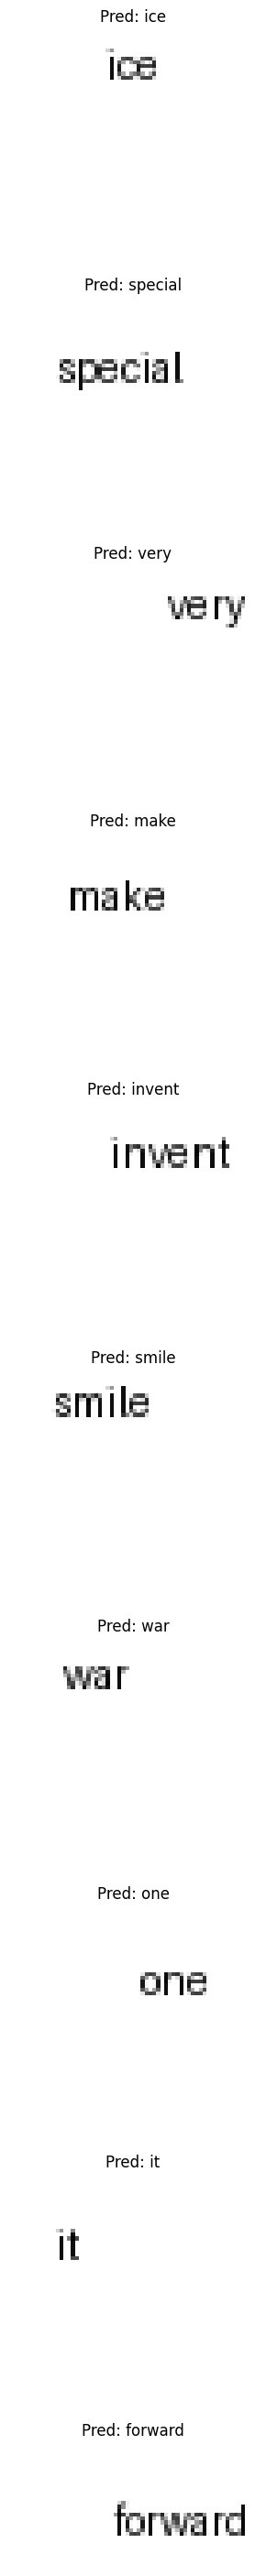

In [141]:
# --- Visualize Predictions (Neural ODE) ---
model.eval()
with torch.no_grad():
    test_images, test_labels = next(iter(test_loader))
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    outputs = model(test_images)
    _, predicted = torch.max(outputs.data, 1)
    print("Visualizing Neural ODE predictions...")
    visualize_samples(test_loader, dataset, predicted=predicted.cpu(), num_samples = 10)

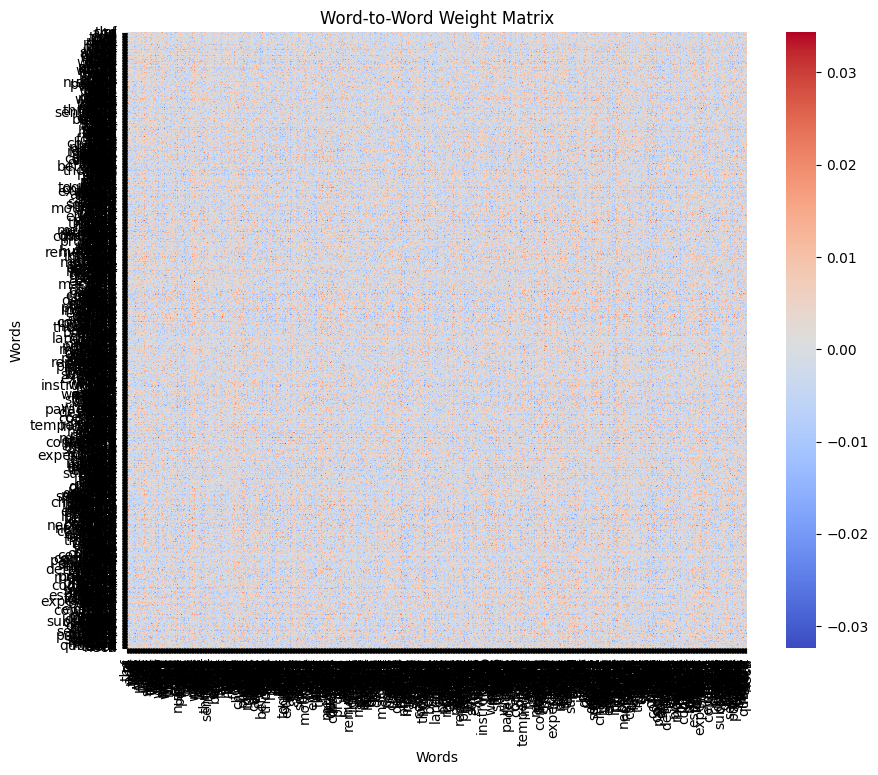

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_interaction_matrix(A, dataset, word_indices=None):
    """
    Visualizes the interaction matrix A, with an option to highlight specific word interactions.

    Args:
        A: the weight matrix
        dataset: The TinySynthWordDataset instance.
        word_indices: A list of word indices to highlight. If None, all word interactions are shown.
    """

    num_hidden = A.shape[0]
    num_words = len(dataset.words)

    # Extract word-to-word interaction submatrix
    word_interaction_matrix = A[-num_words:, -num_words:]

    # Create the heatmap
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed
    sns.heatmap(word_interaction_matrix, cmap="coolwarm", annot=False,
                xticklabels=dataset.words, yticklabels=dataset.words)

    plt.title("Word-to-Word Weight Matrix")
    plt.xlabel("Words")
    plt.ylabel("Words")
    plt.show()

visualize_interaction_matrix(weight_history[-1], dataset)

In [143]:
# Generate Animation with Dynamic Scaling
fig, ax = plt.subplots(figsize=(8, 6))
initial_weights = weight_history[0]
vmin, vmax = initial_weights.min(), initial_weights.max()
im = ax.imshow(initial_weights, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title("Evolution of Weight Matrix")
plt.colorbar(im)

def update(frame):
    weights = weight_history[frame]
    diff = weights #- weight_history[0]
    im.set_data(diff)
    im.set_clim(vmin=diff.min(), vmax=diff.max())
    ax.set_title(f"Weight Matrix Difference - Epoch {frame}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(weight_history), interval=500, blit=True)
ani.save('weight_evolution_diff.mp4', writer='ffmpeg', fps=2)
print("Animation saved as 'weight_evolution_diff.mp4'")
plt.close()

Animation saved as 'weight_evolution_diff.mp4'


In [144]:
# Generate Animation with Dynamic Scaling
fig, ax = plt.subplots(figsize=(8, 6))
initial_weights = weight_history[0][-num_words:, -num_words:]
vmin, vmax = initial_weights.min(), initial_weights.max()
im = ax.imshow(initial_weights, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title("Evolution of SimpleODEFunc Weight Matrix")
plt.colorbar(im)

def update(frame):
    weights = weight_history[frame][-num_words:, -num_words:]
    diff = weights #- weight_history[0]
    im.set_data(diff)
    im.set_clim(vmin=diff.min(), vmax=diff.max())
    ax.set_title(f"Weight Matrix Between Words - Epoch {frame}")
    return [im]

ani = FuncAnimation(fig, update, frames=len(weight_history), interval=500, blit=True)
ani.save('weight_evolution_words.mp4', writer='ffmpeg', fps=2)
print("Animation saved as 'weight_evolution_words.mp4'")
plt.close()

Animation saved as 'weight_evolution_words.mp4'


In [145]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Assume weight_history, dataset, and num_words are defined
fig, ax = plt.subplots(figsize=(8, 6))
initial_weights = weight_history[0][-num_words:, -num_words:]
vmin, vmax = initial_weights.min(), initial_weights.max()

# Create the initial imshow plot with coolwarm colormap
im = ax.imshow(initial_weights, cmap='coolwarm', vmin=vmin, vmax=vmax)

# Set word labels on x and y ticks
ax.set_xticks(np.arange(num_words))  # Set tick positions
ax.set_yticks(np.arange(num_words))
ax.set_xticklabels(dataset.words, rotation=45, ha='right')  # Rotate for readability
ax.set_yticklabels(dataset.words)
ax.set_title("Evolution of SimpleODEFunc Weight Matrix")
plt.colorbar(im)

def update(frame):
    weights = weight_history[frame][-num_words:, -num_words:]
    im.set_data(weights)  # Update the data
    im.set_clim(vmin=weights.min(), vmax=weights.max())  # Dynamic scaling
    ax.set_title(f"Weight Matrix Between Words - Epoch {frame}")
    # No need to reset ticks/ticklabels here; they persist
    return [im]

# Create and save the animation
ani = FuncAnimation(fig, update, frames=len(weight_history), interval=500, blit=True)
ani.save('weight_evolution_words.mp4', writer='ffmpeg', fps=2)
print("Animation saved as 'weight_evolution_words.mp4'")
plt.close()

Animation saved as 'weight_evolution_words.mp4'


Dataset words: ['the', 'of', 'to', 'and', 'a'] ...
Label map for 'there': 40
Number of images: 100000
Number of labels: 100000
Target word: I, Word index: 17
Found image at index 1700 with label 17
Plotting word 'I' at index 17 with label 17 in the dataset
Plotting word 'there' at index 40 with label 40 in the dataset
Plotting word 'that' at index 9 with label 9 in the dataset
Plotting word 'she' at index 49 with label 49 in the dataset
Plotting word 'he' at index 10 with label 10 in the dataset
Plotting word 'they' at index 19 with label 19 in the dataset


<ipython-input-146-56f3014707f1>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


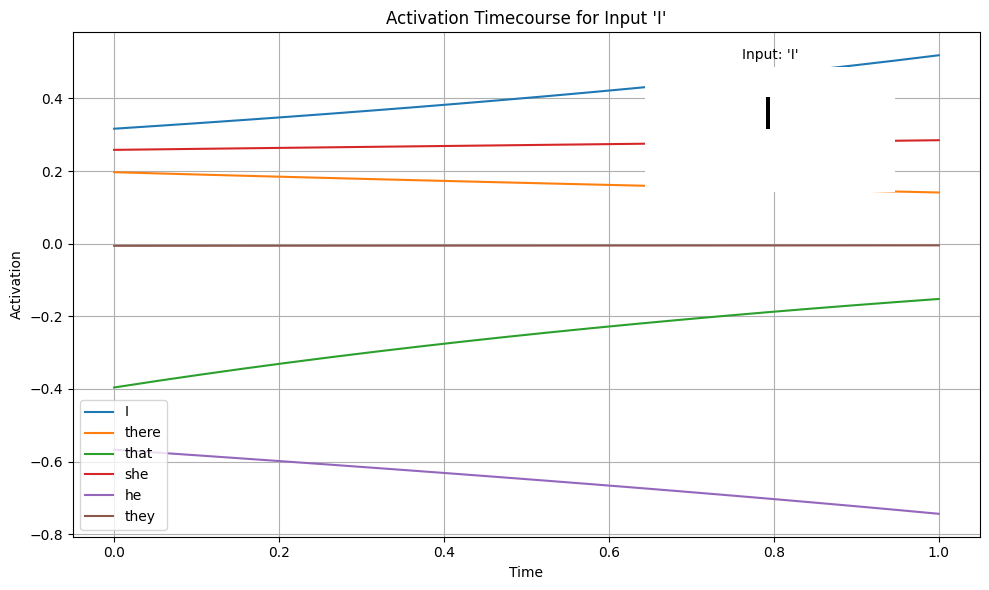

In [146]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming model, dataset, and device are defined
model.eval()

# Debug dataset
print("Dataset words:", dataset.words[:5], "...")  # Should start with ["the", "of", "to", ...]
print("Label map for 'there':", dataset.label_map["there"])  # Should be 40
print("Number of images:", len(dataset.images))
print("Number of labels:", len(dataset.labels))

# Prepare input for target word "to"
target_word = "I"
word_index = dataset.words.index(target_word)
print(f"Target word: {target_word}, Word index: {word_index}")

# Fetch an image explicitly by searching for the correct label
found = False
for idx in range(len(dataset)):
    img, label = dataset[idx]
    if label == dataset.label_map[target_word]:
        input_tensor = img.unsqueeze(0).to(device)  # (1, 1, 64, 32)
        print(f"Found image at index {idx} with label {label}")
        found = True
        break
if not found:
    raise ValueError(f"No image found for {target_word}")

# Define integration time (20 points)
integration_time = torch.linspace(0, 1.0, 20, device=device, dtype=input_tensor.dtype)

# Forward pass
with torch.no_grad():
    trajectory = model(input_tensor, return_all=True)  # (20, 1, num_words)

# Extract word activations, convert to NumPy, define time points
activations = trajectory[:, 0, :].cpu().numpy()  # (20, num_words)
time_points = integration_time.cpu().numpy()  # (20,)

# Select word output units of interest
words_of_interest = [target_word] + ["there", "that", "she", "he", "they"]
indices_of_interest = [dataset.words.index(word) for word in words_of_interest]

# Create plot with inset
fig = plt.figure(figsize=(10, 6))
ax_main = fig.add_subplot(111)

# Plot activation timecourse
for i, (word, windex) in enumerate(zip(words_of_interest, indices_of_interest)):
    print(f"Plotting word '{word}' at index {windex} with label {dataset.label_map[word]} in the dataset")
    ax_main.plot(time_points, activations[:, windex], label=word, linewidth=1.5)
ax_main.set_xlabel("Time")
ax_main.set_ylabel("Activation")
ax_main.set_title(f"Activation Timecourse for Input '{target_word}'")
ax_main.legend()
ax_main.grid(True)

# Inset for input_tensor
ax_inset = fig.add_axes([0.65, 0.65, 0.25, 0.25])  # Top-right
input_img = input_tensor[0, 0].cpu().numpy()  # (64, 32), grayscale
ax_inset.imshow(input_img, cmap='gray')
ax_inset.axis('off')
ax_inset.set_title(f"Input: '{target_word}'", fontsize=10)

plt.tight_layout()
plt.show()

# Debug final activations
#print("Final activations:", activations[-1, :])
#print("Softmax probabilities:", np.exp(activations[-1, :]) / np.sum(np.exp(activations[-1, :])))